# Functions

In [1]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [1]:
import numpy as np
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
import nltk
from nltk.corpus import stopwords
from gensim.models import KeyedVectors


Using TensorFlow backend.


In [2]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 28 13:00:48 2018

@author: rniel
"""
dataset_path = "datasets/polarization/"

def open_uci(x_=[],y_=[],choice=["movie","amazon","yelp"]):
    
    if ("movie" in choice):
        file  = open(dataset_path+"imdb_labelled.txt", "rt")
        content = file.read()
        contents=[]
        contents=content.split("\n")
        del contents[-1]
        for c in contents:
            temp=c.split("\t")
            x_.append(temp[0])
            y_.append(int(temp[1]))

    if ("amazon" in choice):
        file  = open(dataset_path+"amazon_cells_labelled.txt", "rt")
        content = file.read()
        contents=[]
        contents=content.split("\n")
        del contents[-1]

        for c in contents:
            temp=c.split("\t")
            x_.append(temp[0])
            y_.append(int(temp[1]))

    if ("yelp" in choice):
        file  = open(dataset_path+"yelp_labelled.txt", "rt")
        content = file.read()
        contents=[]
        contents=content.split("\n")
        del contents[-1]


        for c in contents:
            temp=c.split("\t")
            x_.append(temp[0])
            y_.append(int(temp[1]))
    return x_,y_

def open_book(x_=[],y_=[]):
    file  = open(dataset_path+"book.txt", "rt")
    
    nb_duplicate = 0
    
    content = file.read()
    contents=[]
    contents=content.split("\n")
    del contents[-1]
    del contents[-1]
    
    for c in contents:
        temp=c.split("\t")
        if(temp[1] in x_):
            nb_duplicate+=1
        else : 
            x_.append(temp[1])
            y_.append(int(temp[0]))  
    return x_,y_

def open_movie(x_=[],y_=[]):
    file  = open(dataset_path+"rt-polarity-neg.txt", "rt",encoding = "ISO-8859-1")

    content = file.read()
    contents=[]
    contents=content.split("\n")
    del contents[-1]
    del contents[-1]

    for i in range(len(contents)):
        x_.append(contents[i])
        y_.append(0)

    file  = open(dataset_path+"rt-polarity-pos.txt", "rt",encoding = "ISO-8859-1")
    content = file.read()
    contents=[]
    contents=content.split("\n")
    del contents[-1]
    del contents[-1]

    for i in range(len(contents)):
        x_.append(contents[i])
        y_.append(1)    
    return x_,y_

def pretreatment(sentences):
    # This function take a list of sentences and treat them to remove all punctuation mark and higher case
    to_delete = [",",".","-","!","?",":","*",")","(","'",'"',"\n","0","1","2","3","4","5","6","7","8","9"]

    for i in range(len(sentences)):
        for t in to_delete:
            sentences[i] = sentences[i].replace(t," ")

    ret_sentences = []
    for s in sentences:
        ret_sentences.append(s.split(" "))

    for i in range(len(sentences)):
        ret_sentences[i]=[w for w in ret_sentences[i] if w!=""]

    for i in range(len(ret_sentences)):
        for j in range(len(ret_sentences[i])) :
            ret_sentences[i][j]=ret_sentences[i][j].lower()
    return ret_sentences
    
def vectorization(sentences,vectors,word_length=300,max_len=50,adaptable_len=False):
    """ This function transform an array of list of words (the splitted sentences) into a array of list of vectors 
            representing the words thanks to an already trained word2Vec model
            
        Keyword arguments:
        sentences -- The different sentences you want to vectorize
        word2vec_model -- An already trained gensim Word2Vec model
        word_length -- The number of dimension of the vectors representing the words (default 300) 
        max_len -- The maximum length of a sentence (default 50) 
        adaptable_len -- A boolean allowing to adapt the maximum length to the longest sentence in your dataset
    """
    sentences_v=[]
    unusued_word=[]

    sp_words = set(stopwords.words('english'))    
    
    for s in sentences:
        temp=[]
        for w in s :
            if(w not in sp_words):
                try :
                    temp.append(np.float32(vectors[w]))
                except : 
                    unusued_word.append(w)
        sentences_v.append(temp)
        
    if (adaptable_len == True):
        for s in sentences_v:
            if(len(s)>max_len):
                max_len=len(s)
                
    for s in sentences_v:
        sentence_length = len(s)
        if(sentence_length<max_len):    
            for j in range(max_len-sentence_length):
                s.append([0]*word_length)
    return sentences_v,max_len

def load_google_word2vec(vocabulary_size = 300000, path = 'lib/GoogleNews-vectors-negative300.bin'):
    # load the google word2vec model
    model = KeyedVectors.load_word2vec_format(path,binary = True,limit=vocabulary_size)  
    return model

def protocol_test(config,model,length_sentences,x_test=[],y_test=[]):

    names = ["amazon","yelp","movies"]
    mean = []
    
    for n in names :
        x, y = open_uci([],[],choice = n)
        for i in range(len(x)) : 
            if("not" in x[i]):
                x[i] = treatment_negation(x[i])
        sentences_v,max_len = vectorization(pretreatment(x),model,word_length=300,max_len=length_sentences,adaptable_len=True)
        y_pred = config.predict(np.array(sentences_v))
        y_pred = np.argmax(y_pred,axis=1)
        cf = confusion_matrix(y,y_pred)
        acc = (cf[0][0]+cf[1][1])/(cf[0][0]+cf[1][1]+cf[0][1]+cf[1][0])
        print("Confusion matrix : \n "+ str (cf))
        mean.append(acc)
        print("Accuracy and loss for the "+str(n)+" dataset : "+ str(acc) +"\n")
    
    print("Mean for the 3 datasets = "+str(np.mean(mean))+"\n")
        
    if (len(x_test)!=0 and len(y_test)!=0):
        y_pred = np.argmax(config.predict(np.array(x_test)),axis=1)
        cf = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
        acc = (cf[0][0]+cf[1][1])/(cf[0][0]+cf[1][1]+cf[0][1]+cf[1][0])
        print("Confusion matrix :\n "+str(cf))
        print("Evaluation on the test set : "+str(acc))
        
def protocol_test_embedding(config,tokenizer,length_sentences,x_test=[],y_test=[]):

    names = ["amazon","yelp","movies"]
    mean = []
    
    for n in names :
        x, y = open_uci([],[],choice = n)
        for i in range(len(x)) : 
            if("not" in x[i]):
                x[i] = treatment_negation(x[i])
            
            sentences_v = []        
            for s in x :
                sentences_v.append(text_to_word_sequence(s))
        sentences_v = tokenize(sentences_v,tokenizer,length_sentences)
        y_pred = config.predict(np.array(sentences_v))
        y_pred = np.argmax(y_pred,axis=1)
        print(len(y_pred))
        cf = confusion_matrix(y,y_pred)
        acc = (cf[0][0]+cf[1][1])/(cf[0][0]+cf[1][1]+cf[0][1]+cf[1][0])
        print("Confusion matrix : \n "+ str (cf))
        mean.append(acc)
        print("Accuracy and loss for the "+str(n)+" dataset : "+ str(acc) +"\n")
    
    print("Mean for the 3 datasets = "+str(np.mean(mean))+"\n")
        
    if (len(x_test)!=0 and len(y_test)!=0):
        y_pred = np.argmax(config.predict(np.array(x_test)),axis=1)
        cf = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
        acc = (cf[0][0]+cf[1][1])/(cf[0][0]+cf[1][1]+cf[0][1]+cf[1][0])
        print("Confusion matrix :\n "+str(cf))
        print("Evaluation on the test set : "+str(acc))

def protocol_test_embedding_gensim(config,word2vec_model,length_sentences,x_test=[],y_test=[]):

    names = ["amazon","yelp","movies"]
    mean = []
    
    for n in names :
        x, y = open_uci([],[],choice = n)
        for i in range(len(x)) : 
            if("not" in x[i]):
                x[i] = treatment_negation(x[i])
            
            sentences_v = []        
            for s in x :
                sentences_v.append(text_to_word_sequence(s))
        sentences_v = tokenize(word2vec_model,sentences_v,length_sentences)
        y_pred = config.predict(np.array(sentences_v))
        y_pred = np.argmax(y_pred,axis=1)
        cf = confusion_matrix(y,y_pred)
        acc = (cf[0][0]+cf[1][1])/(cf[0][0]+cf[1][1]+cf[0][1]+cf[1][0])
        print("Confusion matrix : \n "+ str (cf))
        mean.append(acc)
        print("Accuracy and loss for the "+str(n)+" dataset : "+ str(acc) +"\n")
    
    print("Mean for the 3 datasets = "+str(np.mean(mean))+"\n")
        
    if (len(x_test)!=0 and len(y_test)!=0):
        y_pred = np.argmax(config.predict(np.array(x_test)),axis=1)
        cf = confusion_matrix(np.argmax(y_test,axis=1),y_pred)
        acc = (cf[0][0]+cf[1][1])/(cf[0][0]+cf[1][1]+cf[0][1]+cf[1][0])
        print("Confusion matrix :\n "+str(cf))
        print("Evaluation on the test set : "+str(acc))

        
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/robin/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
def treatment_negation_sentences(sentences):
    ret_sentences = []
    punctuation = [",",".","!","?",":"]

    for s in sentences:
        for p in punctuation :
            s = s.replace(p," "+p)
        ret_sentences.append(s.split(" "))
        
    for s in ret_sentences:
        for i in range(len(s)):
            if (s[i] == 'not'):
                j = i +1
                if (j < len(s)):
                    while (j< len(s) or (not(s[j] in punctuation) and s[j]!= "")):
                        s[j] = "not"+s[j]
                        j+=1
                        if (j>=len(s)):
                            break
        for i in range(len(ret_sentences)):
            ret_sentences[i] = " ".join(ret_sentences[i])

    return ret_sentences

def treatment_negation(sentence):
    
    punctuation = [",",".","!","?",":"]
    sp_words = set(stopwords.words('english'))    

    for p in punctuation :
        sentence = sentence.replace(p," "+p)
    
    sentence = sentence.split(" ")
    
    for i in range(len(sentence)):
        if (sentence[i] == 'not'):
            j = i
            if (j < len(sentence)):
                while (j< len(sentence) and (not(sentence[j] in punctuation) and sentence[j]!= "")):
                    if (sentence[j] == "not"):
                        sentence[j] = ""
                        j+=1
                    elif(not(sentence[j] in punctuation) and (sentence)) : 
                        sentence[j] = "not"+sentence[j]
                        j+=1
                        if (j>=len(sentence)):
                            break
                    else : 
                        j+=1
    sentence = " ".join(sentence)                    
    return sentence
    

# Opening of the data with not propagation

In [4]:
from keras.preprocessing.text import text_to_word_sequence

x,y=[],[]
x,y = open_book(x,y)
x,y = open_movie(x,y)
not_sentences = []
y_not_sentences = []

for i in range(len(x)) :
    if ("not" in x[i]):
        x[i]=treatment_negation(x[i])
        not_sentences.append(x[i])

print("Length of x :"+str(len(x)))
sentences = []
for s in x :
    sentences.append(text_to_word_sequence(s))

Length of x :12070


# Opening of the data without not propagation 

In [4]:
from keras.preprocessing.text import text_to_word_sequence

x,y=[],[]
x,y = open_book(x,y)
x,y = open_movie(x,y)

print("Length of x :"+str(len(x)))
sentences = []
for s in x :
    sentences.append(text_to_word_sequence(s))

Length of x :12070


# Embedding part 

In [5]:
from gensim.models import Word2Vec
word2vec_model = Word2Vec.load("variables/review_rating/not/model")

In [5]:
from gensim.models import Word2Vec
word2vec_model = Word2Vec.load("variables/review_rating/word2vec/300/Model_300")

In [5]:
word2vec_model = load_google_word2vec()

In [6]:
from keras.preprocessing.sequence import pad_sequences

def tokenize(word2vec_model,sentences,length_sentences=None) :
    sentences_t = []
    unusued_words = []
    for s in sentences :
        sentence_tmp = []
        for w in s :
            try:
                sentence_tmp.append(word2vec_model.wv.vocab[w].index) 
            except : 
                unusued_words.append(w)
        sentences_t.append(sentence_tmp)
    
    sentences_ret = pad_sequences(np.array(sentences_t),maxlen=length_sentences)    
    for i in range(len(sentences_ret)):
        sentences_ret[i] = np.flip(sentences_ret[i],axis=0)
        
    return sentences_ret

In [7]:
sentences_toke = tokenize(word2vec_model,sentences)

# Splitting of the data into train and test set (Word2Vec part)

# Word2Vec

In [6]:
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split

x_train,x_test,y_train,y_test = train_test_split(sentences,y,test_size=0.1,random_state =42)
x_vec_train,max_len = vectorization(x_train,word2vec_model.wv,word_length=300,adaptable_len=True)
x_vec_test,ma_len =  vectorization(x_test,word2vec_model.wv,word_length=300,adaptable_len=True)
x_vec_train = np.array(x_vec_train)
x_vec_test = np.array(x_vec_test)
y_vec_train = to_categorical(y_train)
y_vec_test = to_categorical(y_test)

# Splitting of the data into train and test set (Tokens part)

In [8]:
from sklearn.model_selection import train_test_split
import numpy as np
from keras.utils import to_categorical

x_train,x_test,y_train,y_test = train_test_split(sentences_toke,y,test_size=0.1,random_state=42)
x_train=np.array(x_train)
x_test=np.array(x_test)
y_train=to_categorical(y_train)
y_test=to_categorical(y_test)  

# Neural network creation

In [15]:
# Neural Network
def model_creation():
    
    WORD_LENGTH=300
    max_len=50
    
    from keras.models import Sequential
    from keras.layers import Dense, Activation,Convolution1D,Flatten,MaxPooling1D,Conv1D,LSTM
    from keras.layers import Dropout

    NN1 = Sequential()

    NN1.add(Dense(max_len, activation='relu',input_shape=(max_len,WORD_LENGTH)))
    NN1.add(Dropout(0.5))
    
    NN1.add(Convolution1D(64,kernel_size=10,activation='relu',border_mode='causal',input_shape=(max_len,WORD_LENGTH)))
    NN1.add(Dropout(0.5))
    
    NN1.add(MaxPooling1D(pool_size=2, strides=None, padding='same'))

    NN1.add(LSTM(50))
    NN1.add(Dropout(0.5))
    
    NN1.add(Dense(250, activation='relu'))
    NN1.add(Dropout(0.5))
       
    NN1.add(Dense(250, activation='relu'))
    NN1.add(Dropout(0.5))
          
    NN1.add(Dense(2, activation='softmax'))

    NN1.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return NN1

In [7]:
# Neural Network
from keras.layers import Input, Dense,Activation,Convolution1D,Flatten,MaxPooling1D,Conv1D,LSTM,Dropout
from keras.models import Model

def model_creation():
    
    WORD_LENGTH=300
    max_len=50
    inputs = Input((max_len,WORD_LENGTH))
    x = Dropout(0.5)(inputs)
    x = Convolution1D(64,kernel_size=10,activation='relu',border_mode='causal')(x)
    x = Dropout(0.5)(x)
    x = MaxPooling1D(pool_size=2, strides=None, padding='same')(x)
    x = LSTM(50)(x)
    x = Dropout(0.5)(x)
    x = Dense(250, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(250, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(2,activation = "softmax")(x)
    
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [9]:
# Neural Network
from keras.layers import Input, Dense,Activation,Convolution1D,Flatten,MaxPooling1D,Conv1D,LSTM,Dropout, Embedding,BatchNormalization
from keras.models import Model

def model_creation():
    
    max_len=49
    inputs = Input(shape = (max_len,))
    emb = word2vec_model.wv.get_keras_embedding(train_embeddings=True)(inputs)
    #x = Dropout(0.5)(emb)
    x = Dense(max_len, activation='relu')(emb)
    x = Dropout(0.5)(x)    
    x = Convolution1D(64,kernel_size=10,activation='relu',border_mode='causal')(emb)
    #x = BatchNormalization()(x)
    x = Dropout(0.5)(x)
    x = MaxPooling1D(pool_size=2, strides=None, padding='same')(x)
    x = LSTM(50)(x)
    x = Dropout(0.5)(x)
    x = Dense(250, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(250, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(2,activation = "softmax")(x)
    
    model = Model(inputs=inputs, outputs=output)
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [27]:
import time
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

start_time = time.time()
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0,patience=0,verbose=0, mode='auto')

NN = model_creation()

hist_google = NN.fit(x_train, y_train, epochs=15, batch_size=256,validation_split=0.1,callbacks=[checkpointer])
NN.load_weights('weights.hdf5')

print("The training took "+str((time.time()-start_time)/60)+" mn")

/home/robin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, kernel_size=10, activation="relu", padding="causal")`
  del sys.path[0]


Train on 9776 samples, validate on 1087 samples
Epoch 1/15
9776/9776 [==============================] - 6s 617us/step - loss: 0.7072 - acc: 0.5026 - val_loss: 0.6890 - val_acc: 0.5189

Epoch 00001: val_loss improved from inf to 0.68900, saving model to weights.hdf5
Epoch 2/15
9776/9776 [==============================] - 3s 286us/step - loss: 0.6622 - acc: 0.5918 - val_loss: 0.5750 - val_acc: 0.7167

Epoch 00002: val_loss improved from 0.68900 to 0.57501, saving model to weights.hdf5
Epoch 3/15
9776/9776 [==============================] - 3s 280us/step - loss: 0.5760 - acc: 0.7126 - val_loss: 0.5234 - val_acc: 0.7489

Epoch 00003: val_loss improved from 0.57501 to 0.52341, saving model to weights.hdf5
Epoch 4/15
9776/9776 [==============================] - 3s 304us/step - loss: 0.5118 - acc: 0.7697 - val_loss: 0.4940 - val_acc: 0.7700

Epoch 00004: val_loss improved from 0.52341 to 0.49403, saving model to weights.hdf5
Epoch 5/15
9776/9776 [==============================] - 3s 285us/ste

In [19]:
NN.evaluate(x_test,y_test)

1207/1207 [==============================] - 1s 819us/step


[0.4437681279008608, 0.8053024027005838]

In [28]:
protocol_test_embedding_gensim(NN,word2vec_model,49,x_test,y_test)

Confusion matrix : 
 [[450  50]
 [ 98 402]]
Accuracy and loss for the amazon dataset : 0.852

Confusion matrix : 
 [[434  66]
 [154 346]]
Accuracy and loss for the yelp dataset : 0.78

Confusion matrix : 
 [[451  49]
 [135 365]]
Accuracy and loss for the movies dataset : 0.816

Mean for the 3 datasets = 0.816

Confusion matrix :
 [[464 136]
 [133 474]]
Evaluation on the test set : 0.7771333885666943


# Training of the model (without embedding)

In [11]:
import time
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

start_time = time.time()
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0,patience=0,verbose=0, mode='auto')

NN = model_creation()

hist_google = NN.fit(x_vec_train, y_vec_train, epochs=15, batch_size=1028,validation_split=0.1,callbacks=[checkpointer])
NN.load_weights('weights.hdf5')

print("The training took "+str((time.time()-start_time)/60)+" mn")

/home/robin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, kernel_size=10, activation="relu", padding="causal")`
  # This is added back by InteractiveShellApp.init_path()


Train on 9776 samples, validate on 1087 samples
Epoch 1/15
9776/9776 [==============================] - 6s 647us/step - loss: 0.6914 - acc: 0.5396 - val_loss: 0.6706 - val_acc: 0.7065

Epoch 00001: val_loss improved from inf to 0.67058, saving model to weights.hdf5
Epoch 2/15
9776/9776 [==============================] - 2s 204us/step - loss: 0.6209 - acc: 0.7020 - val_loss: 0.5216 - val_acc: 0.7774

Epoch 00002: val_loss improved from 0.67058 to 0.52164, saving model to weights.hdf5
Epoch 3/15
9776/9776 [==============================] - 2s 220us/step - loss: 0.5443 - acc: 0.7513 - val_loss: 0.5008 - val_acc: 0.7755

Epoch 00003: val_loss improved from 0.52164 to 0.50079, saving model to weights.hdf5
Epoch 4/15
9776/9776 [==============================] - 2s 200us/step - loss: 0.5316 - acc: 0.7530 - val_loss: 0.4767 - val_acc: 0.7847

Epoch 00004: val_loss improved from 0.50079 to 0.47672, saving model to weights.hdf5
Epoch 5/15
9776/9776 [==============================] - 2s 205us/ste

# Cross val for batch size

In [8]:
batch_sizes = [16,32,64,128,256,512,1024,2048]

In [9]:
import time
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

start_time = time.time()
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0,patience=0,verbose=0, mode='auto')
ress = []
for batch_size in batch_sizes :
    NN = model_creation()
    hist_google = NN.fit(x_vec_train, y_vec_train, epochs=8, batch_size=batch_size,validation_split=0.1,callbacks=[checkpointer])
    NN.load_weights('weights.hdf5')
    ress.append(NN.evaluate(x_vec_test,y_vec_test))
print("The training took "+str((time.time()-start_time)/60)+" mn")

/home/robin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, kernel_size=10, activation="relu", padding="causal")`
  # This is added back by InteractiveShellApp.init_path()


Train on 9776 samples, validate on 1087 samples
Epoch 1/8
9776/9776 [==============================] - 44s 5ms/step - loss: 0.5742 - acc: 0.6996 - val_loss: 0.5111 - val_acc: 0.7774

Epoch 00001: val_loss improved from inf to 0.51111, saving model to weights.hdf5
Epoch 2/8
9776/9776 [==============================] - 45s 5ms/step - loss: 0.5208 - acc: 0.7483 - val_loss: 0.4707 - val_acc: 0.7783

Epoch 00002: val_loss improved from 0.51111 to 0.47071, saving model to weights.hdf5
Epoch 3/8
9776/9776 [==============================] - 43s 4ms/step - loss: 0.5088 - acc: 0.7581 - val_loss: 0.4470 - val_acc: 0.7921

Epoch 00003: val_loss improved from 0.47071 to 0.44701, saving model to weights.hdf5
Epoch 4/8
9776/9776 [==============================] - 42s 4ms/step - loss: 0.4947 - acc: 0.7623 - val_loss: 0.4464 - val_acc: 0.8022

Epoch 00004: val_loss improved from 0.44701 to 0.44644, saving model to weights.hdf5
Epoch 5/8
9776/9776 [==============================] - 44s 4ms/step - loss: 

1207/1207 [==============================] - 1s 496us/step
Train on 9776 samples, validate on 1087 samples
Epoch 1/8
9776/9776 [==============================] - 4s 400us/step - loss: 0.6895 - acc: 0.5324 - val_loss: 0.6343 - val_acc: 0.7378

Epoch 00001: val_loss did not improve from 0.42958
Epoch 2/8
9776/9776 [==============================] - 2s 196us/step - loss: 0.5790 - acc: 0.7301 - val_loss: 0.5207 - val_acc: 0.7792

Epoch 00002: val_loss did not improve from 0.42958
Epoch 3/8
9776/9776 [==============================] - 2s 196us/step - loss: 0.5386 - acc: 0.7519 - val_loss: 0.4967 - val_acc: 0.7700

Epoch 00003: val_loss did not improve from 0.42958
Epoch 4/8
9776/9776 [==============================] - 2s 196us/step - loss: 0.5177 - acc: 0.7610 - val_loss: 0.4686 - val_acc: 0.7810

Epoch 00004: val_loss did not improve from 0.42958
Epoch 5/8
9776/9776 [==============================] - 2s 199us/step - loss: 0.5092 - acc: 0.7596 - val_loss: 0.4565 - val_acc: 0.7801

Epoch 000

In [10]:
loss = []
acc = []

for r in ress :
    loss.append(r[0])
    acc.append(r[1])

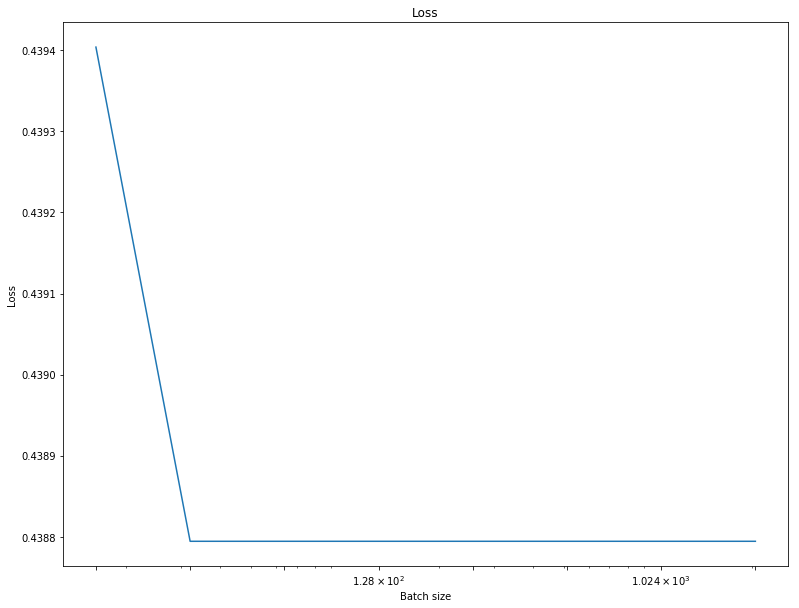

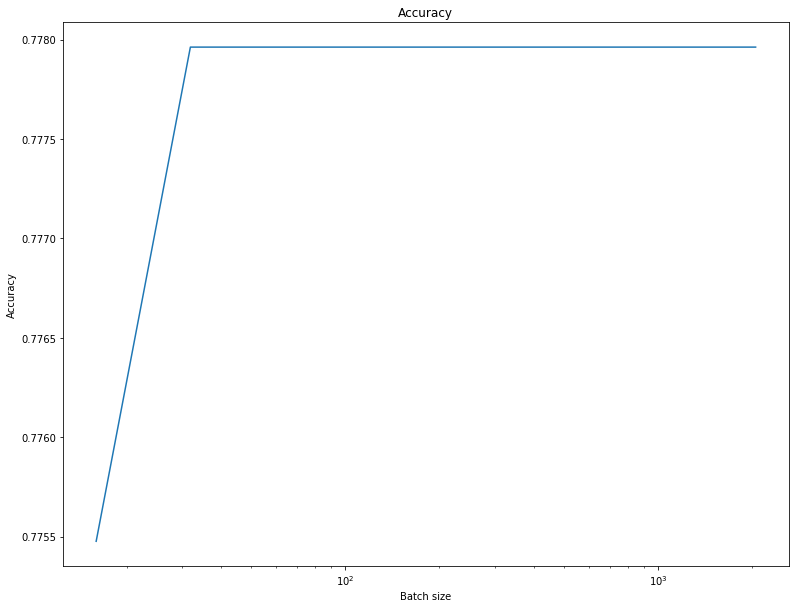

In [14]:
import matplotlib.pyplot as plt
plt.figure(figsize=(13,10))
plt.title("Loss")
plt.xlabel("Batch size")
plt.ylabel("Loss")
plt.semilogx(batch_sizes,loss)
plt.xticks(batch_sizes)
plt.show()
plt.figure(figsize=(13,10))
plt.title("Accuracy")
plt.xlabel("Batch size")
plt.ylabel("Accuracy")
plt.semilogx(batch_sizes,acc)
plt.show()

In [11]:
NN.evaluate(x_vec_test,y_vec_test)

2414/2414 [==============================] - 1s 473us/step


[0.4412678937183102, 0.7920463960725805]

In [12]:
y_pred = NN.predict_classes(x_vec_test)

In [14]:
from sklearn.metrics import confusion_matrix

cf = confusion_matrix(y_test,y_pred)
acc = (cf[0][0]+cf[1][1])/(cf[0][0]+cf[1][1]+cf[0][1]+cf[1][0])
print("Matrice de confusion : \n "+ str (cf))
print("Accuracy : "+ str(acc))

Matrice de confusion : 
 [[913 302]
 [200 999]]
Accuracy : 0.792046396023198


In [26]:
misclassified = []
for i in range(len(x_vec_test)):
    if y_test[i] != y_pred[i] :
        misclassified.append(x_test[i])

In [29]:
for i in range(len(misclassified)):
    misclassified[i] = " ".join(misclassified[i])

In [32]:
for m in misclassified :
    print("=======")
    print(m)

some people want the ol ball and chain and then there are those who just want the ball and chain
[gayton s script] telegraphs every discovery and layers on the gloss of convenience
one hour photo may seem disappointing in its generalities but it s the little nuances that perhaps had to escape from director mark romanek s self conscious scrutiny to happen that finally get under your skin
the best revenge may just be living well because this film unlike other dumas adaptations is far more likened to a treasure than a lengthy jail sentence
watching the film is like reading a times portrait of grief that keeps shifting focus to the journalist who wrote it
shreve s graceful dual narrative gets clunky on the screen and we keep getting torn away from the compelling historical tale to a less compelling soap opera
the movie is well done but slow
you re notmerely notwatching nothistory you re engulfed by it
the results if notmemorable are at least interesting
too much of storytelling moves away 

In [12]:
protocol_test(NN,word2vec_model,50,x_vec_test,y_vec_test)

/home/robin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:135: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).


Confusion matrix : 
 [[472  28]
 [197 303]]
Accuracy and loss for the amazon dataset : 0.775

Confusion matrix : 
 [[460  40]
 [165 335]]
Accuracy and loss for the yelp dataset : 0.795

Confusion matrix : 
 [[460  40]
 [123 377]]
Accuracy and loss for the movies dataset : 0.837

Mean for the 3 datasets = 0.8023333333333333

Confusion matrix :
 [[473 127]
 [138 469]]
Evaluation on the test set : 0.7804473902236951


# Plotting of validation curve

In [33]:
from matplotlib import pyplot as plt

def plot_acc_loss (history,path=""):

    plt.figure(figsize=(13,8))

    #plt.plot(hist_google.history["val_acc"],'r*-')
    #plt.plot(hist_google.history["acc"],'b*-')
    plt.plot(history.history["val_acc"],'r-')
    plt.plot(history.history["acc"],'b-')
    plt.xlabel("epochs")
    plt.ylabel("accuracy")
    plt.legend(("Validation accuracy","Training accuracy"))
    
    if (path != ""):
        plt.savefig(path+"_acc")
    
    plt.show()    

    plt.figure(figsize=(13,8))
    #plt.plot(hist_google.history["val_loss"],'r*-')
    #plt.plot(hist_google.history["loss"],'b*-')
    plt.plot(history.history["val_loss"],'r-')
    plt.plot(history.history["loss"],'b-')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(("Validation loss","Training loss"))
    if (path != ""):
        plt.savefig(path+"_loss")

    plt.show()    

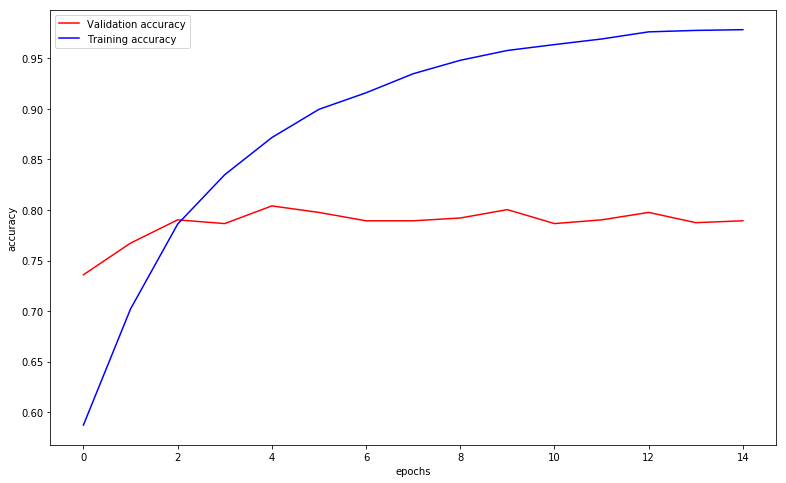

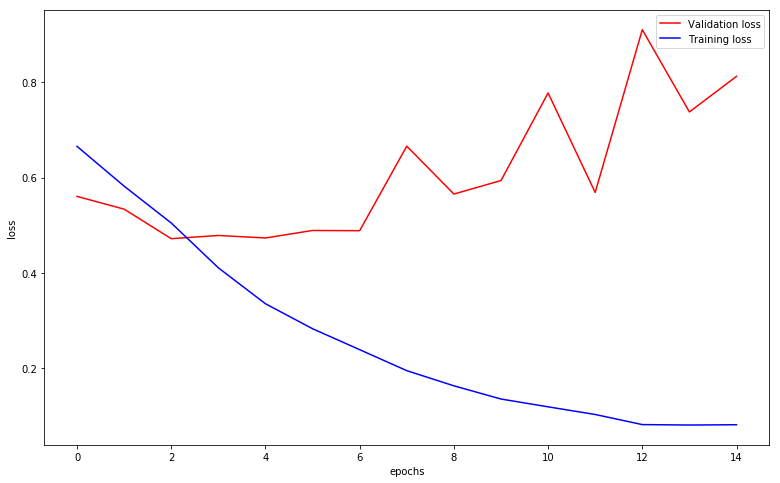

In [34]:
plot_acc_loss(hist_google)

# Training of the model on all the data

In [12]:
from keras.utils import to_categorical
import time
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
import numpy as np
start_time = time.time()
checkpointer = ModelCheckpoint(filepath="weights.hdf5", verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0,patience=0,verbose=0, mode='auto')

NN = model_creation()

hist_google = NN.fit(np.array(sentences_v), to_categorical(y), epochs=20, batch_size=32,validation_split=0.1,callbacks=[checkpointer])
NN.load_weights('weights.hdf5')

print("The training took "+str((time.time()-start_time)/60)+" mn")

/home/robin/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, kernel_size=10, activation="relu", input_shape=(50, 300), padding="causal")`
  app.launch_new_instance()


Train on 10863 samples, validate on 1207 samples
Epoch 1/20
10863/10863 [==============================] - 19s 2ms/step - loss: 0.6373 - acc: 0.6091 - val_loss: 0.8109 - val_acc: 0.5518

Epoch 00001: val_loss improved from inf to 0.81088, saving model to weights.hdf5
Epoch 2/20
10863/10863 [==============================] - 15s 1ms/step - loss: 0.4847 - acc: 0.7785 - val_loss: 0.6205 - val_acc: 0.6603

Epoch 00002: val_loss improved from 0.81088 to 0.62049, saving model to weights.hdf5
Epoch 3/20
10863/10863 [==============================] - 15s 1ms/step - loss: 0.4444 - acc: 0.7966 - val_loss: 0.5181 - val_acc: 0.7283

Epoch 00003: val_loss improved from 0.62049 to 0.51806, saving model to weights.hdf5
Epoch 4/20
10863/10863 [==============================] - 15s 1ms/step - loss: 0.4213 - acc: 0.8114 - val_loss: 0.5966 - val_acc: 0.6446

Epoch 00004: val_loss did not improve from 0.51806
Epoch 5/20
10863/10863 [==============================] - 15s 1ms/step - loss: 0.4074 - acc: 0.81

# Cross validation and model comparaison

In [12]:
def time_estimation_cross_val(nb_epochs,nb_s_epoch,nb_split):
    nb_min = (nb_epochs*nb_s_epoch*nb_split*nb_split)/60
    print("The cross_validation will take around : "+str(nb_min)+" mn")
    return nb_min
    
def cross_val(model_function,x_train,y_train,nb_splits,nb_epochs):
    """ This function allows to do a cross validation over a keras model
        Keyword arguments:
        model_function -- A function returning your model
        x_train -- The train data
        y_train -- The train target
        nb_splits -- The number of folds 
        nb_epochs -- The number of epochs you want to train your network with 
                     /!\ One validation will be a total of nb_folds*nb_epochs total number of epochs
    """
    import time    
    start_time = time.time()
    
    indices = np.linspace(0,len(x_train)-1,num=nb_splits+1,dtype=int)
    split_data = []

    # Creation of the splits
    split_data.append((x_train[indices[0]:indices[1]],y_train[indices[0]:indices[1]]))
    for i in range(1,len(indices)-1):
        split_data.append((x_train[indices[i]+1:indices[i+1]],y_train[indices[i]+1:indices[i+1]]))

    # Cross val    
    score = []
    for i in range(nb_splits):
        model = model_function()
        valid = split_data[i]
        for j in range(nb_splits):
            if (j != i):
                model.fit(split_data[j][0],split_data[j][1],epochs=nb_epochs,batch_size=150)
        score.append(model.evaluate(valid[0],valid[1]))
        
    std = np.std([a[1] for a in score])
    mean = np.mean([a[1] for a in score])
    
    print("Accruracy neural network: "+str(mean*100)+"% +- "+str(std*100)+"%")
    print("--- %s minutes elapsed---" % ((time.time() - start_time)/60))

    return model,score,(mean,std)


def multi_cross_val(model_functions,x_train,y_train,nb_splits,nb_epochs):
    """ This function allows to compare different models over a k-fold cross validation
        Keyword arguments:
        model_functions -- A list containing the functions returning the different models you want to test
        x_train -- The train data
        y_train -- The train target
        nb_splits -- The number of folds 
        nb_epochs -- The number of epochs you want to train your network with 
                     /!\ One validation will be a total of nb_folds*nb_epochs total number of epochs
    """
    import time
    
    start_time = time.time()
    
    indices = np.linspace(0,len(x_train)-1,num=nb_splits+1,dtype=int)
    split_data = []

    # Creeation of the splits
    split_data.append((x_train[indices[0]:indices[1]],y_train[indices[0]:indices[1]]))
    for i in range(1,len(indices)-1):
        split_data.append((x_train[indices[i]+1:indices[i+1]],y_train[indices[i]+1:indices[i+1]]))

    # Cross val    
    score = []
    for i in range(nb_splits):
        print("Split no :"+str(i))
        models = [f() for f in model_functions]
        valid = split_data[i]
        for j in range(nb_splits):
            if (j != i):
                for m in models :
                    try : 
                        m.fit(split_data[j][0],split_data[j][1],epochs=nb_epochs,batch_size=150)
                    except :
                        print(m.summary())
        for k in range(len(models)) :
            score.append((k,models[k].evaluate(valid[0],valid[1])))
    std = {}
    mean = {}
    
    for i in range(len(models)):
        tmp = [s for s in score if s[0]==i]
        std[i]=np.std([a[1][1] for a in tmp])
        mean[i]=np.mean([a[1][1] for a in tmp])

    for k in mean.keys():
        print("Accruracy neural network"+str(k) +" : "+str(mean[k]*100)+"% +- "+str(std[k]*100)+"%")
    
    print("--- %s minutes elapsed---" % ((time.time() - start_time)/60))

    return models,score,mean,std

# Saving of the model

In [14]:
def save_model(model,name,path):
    model_json = model.to_json()
    with open(path+name+".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
        model.save_weights(path+name+".h5")
        print("Saved model to disk")
        
def load_model(name,path):
    from keras.models import model_from_json
    # load json and create model
    json_file = open(path+name+'.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = model_from_json(loaded_model_json)
    # load weights into new model
    loaded_model.load_weights(path+name+".h5")
    print("Loaded model from disk")
    return loaded_model


In [118]:
save_model(NN,"Final","models/")

Saved model to disk


In [15]:
NN_loaded = load_model("labelled+books_final","models/")
NN_loaded.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

Loaded model from disk


In [16]:
NN_loaded.evaluate(x_vec_test,y_vec_test)

ValueError: Error when checking input: expected dense_39_input to have 3 dimensions, but got array with shape (882, 50)

# Utilisation of the model for live prediction

In [41]:
def vote(score):
    import numpy as np
    neg=[]
    pos=[]
    for s in score :
        neg.append(s[0][0])
        pos.append(s[0][1])
    sup_neg = [n for n in neg if n > 0.5]
    sup_pos = [p for p in pos if p > 0.5]

    return [np.mean(neg),np.mean(pos)]
    
def predict(sentence,word2Vec_model,model,max_len=50,word_length=300):
    import numpy as np
    if ("not" in sentence):
        sentence = treatment_negation(sentence)
    sentence = sentence.split(" ")
    good_sentence = []
    unusued_words = []
    for i in range(len(sentence)):
        try :
            sentence[i]=sentence[i].lower()
            good_sentence.append(word2Vec_model.wv[sentence[i]])
        except : 
            unusued_words.append(sentence[i])
    sentence_length = len(good_sentence)
    
    if(sentence_length<max_len):    
        for j in range(max_len-sentence_length):
            good_sentence.append([0]*word_length)     
            
    if (sentence_length > max_len) :
        predictions = []
        ind = 0
        for i in range(int(np.ceil(sentence_length/max_len))):
            sent_tmp = good_sentence[ind:ind+max_len]
            if(len(sent_tmp)<max_len):
                for j in range(max_len-len(sent_tmp)):
                    sent_tmp.append([0]*word_length)    
            sent_tmp = np.array(sent_tmp)        
            sent_tmp = np.reshape(sent_tmp, (1,sent_tmp.shape[0], sent_tmp.shape[1]))
            try :
                predictions.append(model.predict(sent_tmp))
                ind+=max_len                    
            except : 
                print("Erreur au découpage no :"+str(i))
        return vote(predictions)
    
    good_sentence = np.array(good_sentence)
    good_sentence = np.reshape(good_sentence, (1,good_sentence.shape[0], good_sentence.shape[1]))
    return np.squeeze(model.predict(good_sentence))

In [43]:
best=NN
sentence =input()
print(" Négatif        Positif")
print(predict(sentence,model,best))

It was not bad at all
 Négatif        Positif
[0.69713956 0.30286047]


In [41]:
def test(word2Vec_model,model):
    # This function take an already trained model return the accuracy of the model over an external dataset 
    y=[]
    y_pred=[]
    cnt = 1

    with open("datasets/polarization/rt-polarity-neg.txt","rt",encoding = "ISO-8859-1") as fp:
            line = fp.readline()
            while line:
                y.append(0)
                y_pred.append(predict(line,word2Vec_model,model))
                line = fp.readline()
                cnt += 1
                
    with open("datasets/polarization/rt-polarity-pos.txt","rt",encoding = "ISO-8859-1") as fp:
            line = fp.readline()
            while line:
                y.append(1)
                y_pred.append(predict(line,word2Vec_model,model))
                line = fp.readline()
                cnt += 1
                
    print(str(cnt)+" lines tested")
    
    y_pred_trans=[]  
    
    for i in range(len(y_pred)):
        try : 
            if(y_pred[i][0]>y_pred[i][1]):
                y_pred_trans.append(0)
            else :
                y_pred_trans.append(1)
        except : 
            print("Bug ligne : "+str(i))
    from sklearn.metrics import confusion_matrix
    cf = confusion_matrix(y,y_pred_trans)
    acc = (cf[0][0]+cf[1][1])/(cf[0][0]+cf[1][1]+cf[0][1]+cf[1][0])
    print("Confusion matrix : \n "+ str (cf))
    print("Accuracy : "+ str(acc))
    

In [42]:
test(model,best)

10663 lines tested
Confusion matrix : 
 [[3643 1688]
 [1153 4178]]
Accuracy : 0.7335396736072032


In [39]:
models = []
for i in range(len(functions)) :
    models.append(functions[i]())
    models[i].fit(np.array(sentences_v),to_categorical(y),epochs=30,batch_size=100)
    print("Neural network "+str(i))
    test(model,models[i])

Epoch 1/30
4410/4410 [==============================] - 4s 857us/step - loss: 0.6928 - acc: 0.5204
Epoch 2/30
4410/4410 [==============================] - 1s 210us/step - loss: 0.6608 - acc: 0.6009
Epoch 3/30
4410/4410 [==============================] - 1s 205us/step - loss: 0.5886 - acc: 0.6902
Epoch 4/30
4410/4410 [==============================] - 1s 213us/step - loss: 0.5147 - acc: 0.7628
Epoch 5/30
4410/4410 [==============================] - 1s 198us/step - loss: 0.4738 - acc: 0.7785
Epoch 6/30
4410/4410 [==============================] - 1s 195us/step - loss: 0.4495 - acc: 0.7950
Epoch 7/30
4410/4410 [==============================] - 1s 195us/step - loss: 0.4296 - acc: 0.8000
Epoch 8/30
4410/4410 [==============================] - 1s 197us/step - loss: 0.4074 - acc: 0.8209
Epoch 9/30
4410/4410 [==============================] - 1s 197us/step - loss: 0.3888 - acc: 0.8340
Epoch 10/30
4410/4410 [==============================] - 1s 209us/step - loss: 0.3882 - acc: 0.8317
Epoch 11/

/home/robin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:21: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).


10663 lines tested
Confusion matrix : 
 [[3427 1904]
 [1437 3894]]
Accuracy : 0.6866441568186081


/home/robin/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(64, kernel_size=10, activation="relu", input_shape=(50, 300), padding="causal")`
  app.launch_new_instance()


Epoch 1/30
4410/4410 [==============================] - 5s 1ms/step - loss: 0.6986 - acc: 0.5010
Epoch 2/30
4410/4410 [==============================] - 2s 506us/step - loss: 0.6732 - acc: 0.5685
Epoch 3/30
4410/4410 [==============================] - 2s 523us/step - loss: 0.5872 - acc: 0.6884
Epoch 4/30
4410/4410 [==============================] - 2s 528us/step - loss: 0.5293 - acc: 0.7476
Epoch 5/30
4410/4410 [==============================] - 2s 564us/step - loss: 0.4928 - acc: 0.7803
Epoch 6/30
4410/4410 [==============================] - 2s 557us/step - loss: 0.4610 - acc: 0.7866
Epoch 7/30
4410/4410 [==============================] - 2s 533us/step - loss: 0.4613 - acc: 0.7878
Epoch 8/30
4410/4410 [==============================] - 2s 531us/step - loss: 0.4293 - acc: 0.8066
Epoch 9/30
4410/4410 [==============================] - 2s 521us/step - loss: 0.4037 - acc: 0.8209
Epoch 10/30
4410/4410 [==============================] - 2s 517us/step - loss: 0.4018 - acc: 0.8197
Epoch 11/30

### Second dataset

In [44]:
import glob
path = 'datasets/polarization/txt_sentoken/pos/*.txt'   
files=glob.glob(path)   
sentences_test = []
y_test = []
for file in files:
    f=open(file, 'r')  
    sentences_test.append(f.read())
    y_test.append(1)
    f.close()
    
path = 'datasets/polarization/txt_sentoken/neg/*.txt'   
files=glob.glob(path)
for file in files:
    f=open(file, 'r')  
    sentences_test.append(f.read())
    y_test.append(0)
    f.close()

In [46]:
from sklearn.metrics import confusion_matrix

y_pred = []
for s in sentences_test:
    y_pred.append(predict(s,model,best))
y_pred_trans=[]

i=0
for y_tmp in y_pred:
    i+=1
    if(y_tmp[0] > y_tmp[1]):
        y_pred_trans.append(0)
    else :
        y_pred_trans.append(1)
        
cf = confusion_matrix(y_test,y_pred_trans)
acc = (cf[0][0]+cf[1][1])/(cf[0][0]+cf[1][1]+cf[0][1]+cf[1][0])
print("Matrice de confusion : \n "+ str (cf))
print("Accuracy : "+ str(acc))

Matrice de confusion : 
 [[769 231]
 [277 723]]
Accuracy : 0.746


# Annexe umap

In [7]:
x_resh = np.array(sentences_v)

In [8]:
x_resh = np.reshape(x_resh,(len(x_resh),15000))


In [9]:
from sklearn.preprocessing import normalize
x_resh = normalize(x_resh)

In [10]:
indices = list(range(len(x_resh)))
indices = np.random.choice(indices,3000,replace = False)
tmp = []
y_tmp = []
for i in indices :
    tmp.append( x_resh[i,:])
    y_tmp.append(y[i])

In [25]:
from plot_repr import plot_repr
import umap
import time
import matplotlib.pyplot as plt
t = time.time()
embedding = umap.UMAP(n_neighbors=10,
                      min_dist=0.001,
                      metric='correlation').fit_transform(sentences_tmp)
t = time.time() - t

/home/robin/anaconda3/lib/python3.6/site-packages/umap/rp_tree.py:712: UserWarning: Random Projection forest initialisation failed due to recursionlimit being reached. Something is a little strange with your data, and this may take longer than normal to compute.
  "Random Projection forest initialisation failed due to recursion"


In [26]:
neg,pos = [],[]
for i in range(len(embedding)):
    if(y[i]==1):
        pos.append(embedding[i])
    else :
        neg.append(embedding[i])
neg = np.array(neg)
pos = np.array(pos)

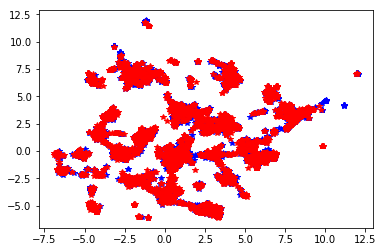

In [27]:

plt.plot(pos[:,0],pos[:,1],"b*")
plt.plot(neg[:,0],neg[:,1],"r*")